In [565]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

data = pd.read_csv('module_2.csv')

# просмотрим базовую информацию о датасете
data.info()

## Вывод:
# В датасете 17 строковых столбцов, 16 столбцов типа float, 1 столбец типа int
# В датасете содержится 395 строк (записей)
# Часть данных отсутсвует

## Вспомогательные функции

def values_outside_iqr_for(series):
    median = series.median()
    print('Медиана ' + series.name + ' = ' + str(median))
    iqr = series.quantile(0.75) - series.quantile(0.25)
    print('IQR ' + series.name + ' = ' + str(iqr))
    lower_bound = median - (1.5 * iqr)
    upper_bound = median + (1.5 * iqr)
    print('Нижняя граница выброса ' + series.name + ' = ' + str(lower_bound))
    print('Верхняя граница выброса ' + series.name + ' = ' + str(upper_bound))
    return series.between(lower_bound, upper_bound)
    
def display_normalized_values_for(series):
    print(data[series.name].value_counts(dropna=False, normalize=True).head(10))
    
def display_absent_values_for(series):
    display(data.loc[data[series.name].isna()])
    
def replace_yes_no_with_integers_in(series):
    data[series.name] = data[series.name].apply(lambda x: None if x == None else 1 if x == 'yes' else 0)
    
def replace_empty_string_values_in(series):
    series.apply(lambda x: None if x.strip() == '' else x.strip())

## переименуем некоторые столбцы для большего удобства использования
data.rename(columns={'famsize': 'family_size',
                     'Pstatus': 'parents_status',
                     'Medu': 'm_education',
                     'Fedu': 'f_education',
                     'Mjob': 'm_job',
                     'Fjob': 'f_job',
                     'schoolsup': 'school_support',
                     'famsup': 'family_support',
                     'famrel': 'family_relations',
                     'studytime, granular': 'studytime_granular',
                     'goout': 'go_out'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [566]:
## Разберем основные числовые столбцы

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64
Медиана age = 17.0
IQR age = 2.0
Нижняя граница выброса age = 14.0
Верхняя граница выброса age = 20.0


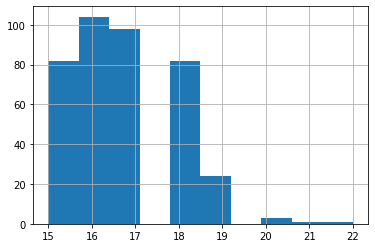

In [567]:
# age
data.age.hist()
print(data.age.describe())

# видим что есть ученики старше 20 лет, сложно представить школьника старше 20 лет, к тому же
# таковые значения являются выбросами, следовательно отбросим их
data = data.loc[values_outside_iqr_for(data.age)]

count    390.000000
mean       2.753846
std        1.097285
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: m_education, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,NaN,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,NaN,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


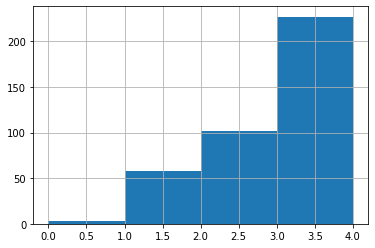

In [568]:
# m_education
data.m_education.hist(bins=4)
print(data.m_education.describe())
#видим что большинство матерей имеют высшее либо среднее-специальное образование, часть данных отсутсвует
#рассмотрим отсутствующие данные
display_absent_values_for(data.m_education)

#строка с индексом 239 содержит большое количество пропусков (m/f_education, internet, romantic)
#к тому же значение score = 0. Отбросим ее
data = data.drop(index=239)

#в остальных случаях заменим пропуски на образование, соответствующее образованию отца
data.m_education = np.where(data.m_education.isna(), data['f_education'], data['m_education'])

count    368.000000
mean       2.625000
std        2.234392
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: f_education, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
21,GP,M,15,U,GT3,T,4.0,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4.0,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3.0,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4.0,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4.0,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3.0,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0


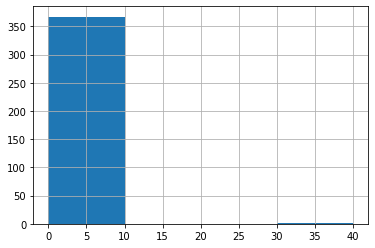

In [569]:
# f_education
data.f_education.hist(bins=4)
print(data.f_education.describe())
# Видим в этом столбце выброс в виде значения 40. 
# предположим что это ошибочное значение, правильное значение должно быть 4 (высшее образование)
data.loc[(data['f_education'] == 40), 'f_education'] = 4

#рассмотрим отсутсвующие данные
display_absent_values_for(data.f_education)

#для отсутствующих значений используем тот же прием, что и с образованием матери
#т.e. предположим что образование отца соответствует образованию матери
data.f_education = np.where(data.f_education.isna(), data['m_education'], data['f_education'])

In [570]:
# traveltime
print(data.traveltime.describe())
display_normalized_values_for(data.traveltime)

# видим что часть данных отсутсвует, рассмотрим отстутвующие данные
display_absent_values_for(data.traveltime)

# заменим отсутсвующие данные в зависимости от типа места жительства
# очевидно, что живущие в городе тратят меньше времени на путь в школу, чем живущие в деревне
# найдем медианные значения для каждого из типов места жительства, и заменим отсутсвующие значения
data.groupby(by=['address'])['traveltime'].median()

# видим что для деревни traveltime составляет 2, для города 1
# если тип адреса так же неизвестен, то опустим такую строку
data = data.dropna(subset=['address', 'traveltime'], how='all')
data.loc[(data['address'] == 'U') & (data['traveltime'].isna()), 'traveltime'] = 1
data.loc[(data['address'] == 'R') & (data['traveltime'].isna()), 'traveltime'] = 2


count    364.000000
mean       1.442308
std        0.695892
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64
1.0    0.609694
2.0    0.244898
NaN    0.071429
3.0    0.056122
4.0    0.017857
Name: traveltime, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,no,yes,NaN,no,yes,-3.0,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
30,GP,M,15,U,GT3,T,4.0,4.0,health,services,home,mother,NaN,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,4.0,2.0,NaN,0.0,60.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,other,father,NaN,1.0,0.0,NaN,yes,no,yes,yes,-3.0,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
37,GP,M,16,R,GT3,A,4.0,4.0,other,teacher,reputation,mother,NaN,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,2.0,4.0,3.0,5.0,7.0,75.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,NaN,2.0,NaN,yes,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
132,GP,F,17,U,LE3,T,2.0,2.0,other,other,course,father,NaN,1.0,0.0,no,yes,no,no,yes,-3.0,yes,NaN,yes,3.0,4.0,4.0,5.0,12.0,60.0


count    382.000000
mean       2.039267
std        0.842461
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,NaN,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,NaN,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,1.0,NaN,1.0,yes,no,no,yes,yes,NaN,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,NaN,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0


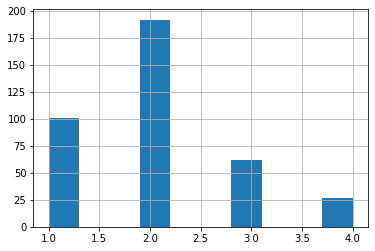

In [571]:
# studytime

print(data.studytime.describe())
data.studytime.hist()
# видим что подавляющее большинство учеников занимаются дополнительно 2-5 часов (2)
# часть данных отсутсвует. рассмотрим отсутсвующие данные

display_absent_values_for(data.studytime)

# считаю что данные о дополнитльном обучении достаточно важная информация, 
# которая оказывает существенное влияние на итоговый результат, поэтому замена
# отсутсвующих данных может существенно исказать результат,
# в связи с этим отбросим записи с отсутсвующими данными,
# к тому же, в каждой из данных строк отсутсвует большое количество информации и 
# по остальным признакам
data = data.dropna(subset=['studytime'], how='all')

0.0    0.748691
1.0    0.123037
NaN    0.054974
2.0    0.039267
3.0    0.034031
Name: failures, dtype: float64


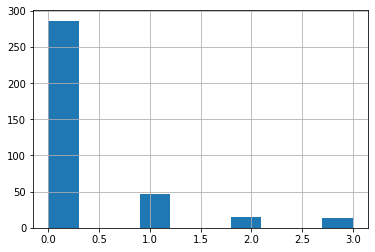

In [572]:
# failures
data.failures.hist()
display_normalized_values_for(data.failures)

# видим что 75% учеников не испытвали внешкольных неудач. 5% данных отсутсвует
# достаточно сложно интерпретировать данные из этого столбца,
# поэтому предлагаю заменить отсутсвующие данные на значение моды (0)
data.failures = data.failures.fillna(0)

-6.0     0.502618
-3.0     0.264398
-9.0     0.162304
-12.0    0.070681
Name: studytime_granular, dtype: float64


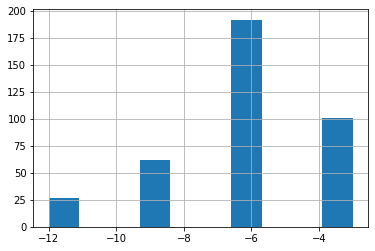

In [573]:
# studytime_granular
data.studytime_granular.hist()
display_normalized_values_for(data.studytime_granular)

# если я правильно понимаю, то этот столбец содержит значение часов из столбцa studytime
# мы уже обработали столбец studytime, по сути эти данные просто дублируются
# (к тому же, почему-то со значением -), поэтому удалим этот столбец

data.drop(['studytime_granular'], inplace=True, axis=1)

count    356.000000
mean       3.929775
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relations, dtype: float64
 4.0    0.471204
 5.0    0.243455
 3.0    0.151832
 NaN    0.068063
 2.0    0.044503
 1.0    0.018325
-1.0    0.002618
Name: family_relations, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,course,father,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,NaN,no,NaN,3.0,3.0,5.0,2.0,70.0
20,GP,M,15,U,GT3,T,4.0,3.0,teacher,other,reputation,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,75.0
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,course,father,1.0,1.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,NaN,4.0,1.0,1.0,0.0,55.0
72,GP,F,15,R,GT3,T,1.0,1.0,other,other,reputation,mother,1.0,2.0,2.0,yes,yes,no,no,no,yes,yes,yes,NaN,3.0,4.0,5.0,2.0,25.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,NaN,3.0,2.0,5.0,2.0,70.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
102,GP,M,15,U,GT3,T,4.0,4.0,services,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,no,yes,yes,no,NaN,3.0,3.0,5.0,4.0,70.0
118,GP,M,17,R,GT3,T,1.0,3.0,other,NaN,course,father,3.0,2.0,1.0,no,yes,no,yes,yes,yes,NaN,no,NaN,2.0,4.0,5.0,20.0,40.0


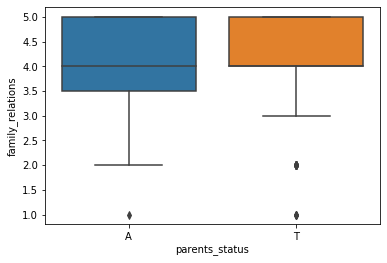

In [574]:
# family_relations
print(data.family_relations.describe())
display_normalized_values_for(data.family_relations)

# видим отрицательное значение -1, предположим что значение должно быть положительным и исправим это
data.loc[(data['family_relations'] == -1), 'family_relations'] = 1

# видим что отсутсвует около 7% данных, что довольно много, рассмотрим их
display_absent_values_for(data.family_relations)

# предлагаю удалить строки, в которых нет данных о семейных отношениях
# и семейной помощи в обучении (family_support), поскольку это достаточно важная информация
# которая оказывает существенное влияние
data = data.dropna(subset=['family_relations', 'family_support'], how='all')

# рассмотрим зависимость семейных отношений и совместного/раздельного проживания родителей
sns.boxplot(x ='parents_status', y = 'family_relations', data = data)

# очевидно, что в семьях где родители живут раздельно, отношения чуть хуже
# однако медианное значение для таких семей = 4.
# поэтому предлагаю заменить отсутсвующие значения в family_relations
# в семьях где родители живут вместе на 5, а где раздельно - на 4
data.loc[(data['parents_status'] == 'A') & (data['family_relations'].isna()), 'family_relations'] = 4
data.loc[(data['parents_status'] == 'T') & (data['family_relations'].isna()), 'family_relations'] = 5

In [575]:
# freetime
print(data.freetime.describe())
display_normalized_values_for(data.freetime)

# видим что отсутствует небольшая часть значений (2.5%), рассмотрим их
display_absent_values_for(data.freetime)

# полагаю что будет логичным заменить отсутсвующие значения в данном случае
# на значения из столбца go_out. поскольку очевидно что если ты проводишь много времени с друзьями
# то у тебя много свободного времени, и наоборот :)
data.freetime = np.where(data.freetime.isna(), data['go_out'], data['freetime'])

count    370.000000
mean       3.218919
std        0.978450
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64
3.0    0.392105
4.0    0.284211
2.0    0.165789
5.0    0.089474
1.0    0.042105
NaN    0.026316
Name: freetime, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
201,GP,F,16,U,GT3,T,2.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,yes,yes,NaN,yes,yes,yes,no,no,4.0,NaN,3.0,4.0,6.0,NaN
280,GP,M,17,U,NaN,A,4.0,4.0,services,other,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0
283,GP,F,18,U,GT3,T,1.0,1.0,other,other,home,mother,2.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,NaN,4.0,4.0,4.0,NaN
290,GP,M,18,U,GT3,T,4.0,4.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,5.0,NaN,2.0,5.0,11.0,55.0
291,GP,F,17,U,GT3,T,4.0,3.0,NaN,services,reputation,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,NaN,2.0,3.0,0.0,75.0
311,GP,F,19,U,GT3,T,2.0,1.0,at_home,other,other,other,3.0,2.0,0.0,no,yes,no,no,yes,no,yes,yes,3.0,NaN,1.0,2.0,20.0,65.0
338,GP,F,18,U,LE3,T,3.0,3.0,services,services,home,mother,1.0,4.0,0.0,no,yes,no,no,yes,yes,yes,no,5.0,NaN,3.0,1.0,7.0,85.0


In [576]:
# go_out
print(data.go_out.describe())
display_normalized_values_for(data.go_out)

# видим что отсутствует небольшая часть значений (1.8%), рассмотрим их
display_absent_values_for(data.go_out)

# поступим аналогично предыдущему случаю, и подставим вместо отсутсвующих значений
# значения из столбца freetime
data.go_out = np.where(data.go_out.isna(), data['freetime'], data['go_out'])

count    373.000000
mean       3.104558
std        1.110703
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: go_out, dtype: float64
3.0    0.323684
2.0    0.255263
4.0    0.215789
5.0    0.128947
1.0    0.057895
NaN    0.018421
Name: go_out, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
89,GP,M,16,U,LE3,A,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,no,no,yes,yes,no,no,4.0,1.0,NaN,5.0,18.0,35.0
92,GP,F,16,NaN,LE3,T,1.0,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
200,GP,F,16,U,GT3,T,4.0,3.0,health,other,home,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,NaN,2.0,2.0,80.0
202,GP,F,17,U,NaN,T,1.0,1.0,other,other,course,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,no,no,4.0,4.0,NaN,1.0,4.0,50.0
221,GP,F,17,U,NaN,T,1.0,1.0,at_home,other,reputation,mother,1.0,3.0,1.0,no,yes,no,yes,yes,yes,no,yes,4.0,3.0,NaN,5.0,0.0,0.0
312,GP,M,19,U,GT3,T,1.0,2.0,other,services,course,other,1.0,2.0,1.0,no,no,no,no,no,yes,yes,no,4.0,5.0,NaN,4.0,3.0,NaN
322,GP,F,17,R,LE3,T,2.0,2.0,services,services,course,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,no,3.0,3.0,NaN,3.0,3.0,55.0


count    366.000000
mean       3.538251
std        1.399574
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64
5.0    0.355263
3.0    0.223684
4.0    0.155263
1.0    0.118421
2.0    0.110526
NaN    0.036842
Name: health, dtype: float64


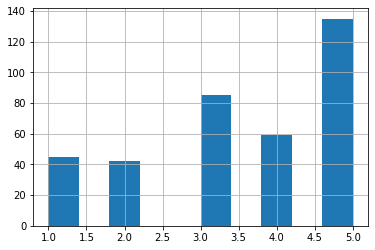

In [577]:
# health
print(data.health.describe())
display_normalized_values_for(data.health)
data.health.hist()

# видим что бОльшая часть студентов чувствуют себя замечательно
# и можем лишь посочувствовать 22% у которых не все хорошо со здоровьем
# пока нет понимания как можно заменить отсутсвующие значения,
# возможно следовало бы удалить строки с отсутвующими данными по здоровью,
# поскольку это весьма важный фактор, который нельзя не учитывать,
# однако пока предлагаю оставить как есть, возможно в дальнейшем мы как-либо обработаем эти данные

count    370.000000
mean       7.172973
std       23.591311
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64
0.0     0.284211
2.0     0.152632
4.0     0.134211
6.0     0.078947
8.0     0.052632
10.0    0.044737
12.0    0.031579
14.0    0.028947
NaN     0.026316
3.0     0.018421
Name: absences, dtype: float64
Медиана absences = 4.0
IQR absences = 8.0
Нижняя граница выброса absences = -8.0
Верхняя граница выброса absences = 16.0


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score


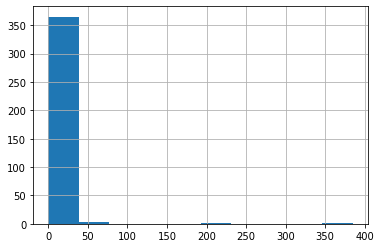

In [578]:
# absences
print(data.absences.describe())
display_normalized_values_for(data.absences)
data.absences.hist()

# очевидны проблемы с этим столбцом, сразу же явно видны выбросы
# (ну либо они просто перестали ходить в школу :) )
# поэтому избавимся от выбросов
data = data.loc[values_outside_iqr_for(data.absences)]

display_absent_values_for(data.absences)

#отсутвующих значений нет

count    338.000000
mean      51.982249
std       23.218220
min        0.000000
25%       41.250000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64
50.0    0.139942
55.0    0.119534
0.0     0.102041
75.0    0.084548
70.0    0.078717
60.0    0.078717
65.0    0.072886
40.0    0.069971
45.0    0.067055
80.0    0.046647
Name: score, dtype: float64
Медиана score = 55.0
IQR score = 28.75
Нижняя граница выброса score = 11.875
Верхняя граница выброса score = 98.125


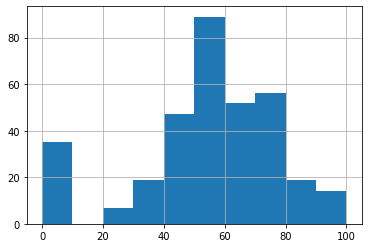

In [579]:
# score
print(data.score.describe())
display_normalized_values_for(data.score)
data.score.hist()

# явно видно нормальное распределение оценок, при этом имеются
# выбросы/отсутсвующие данные в виде оценок 0, избавимся от них
data = data.loc[values_outside_iqr_for(data.score)]

# в результате этого мы так же избавились от результата 100
# (верхняя граница 98.125), но предлагаю не рассматривать вундеркиндов,
# а исследовать обычных студентов/школьников :)

In [580]:
## подведем итоги обработки числовых столбцов
data.info()

# видим что в результате обработки всех числовых столбцов мы исключили ряд записей
# по разным причинам. Осталось 302 записи

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 394
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   school            302 non-null    object 
 1   sex               302 non-null    object 
 2   age               302 non-null    int64  
 3   address           292 non-null    object 
 4   family_size       285 non-null    object 
 5   parents_status    271 non-null    object 
 6   m_education       302 non-null    float64
 7   f_education       302 non-null    float64
 8   m_job             288 non-null    object 
 9   f_job             277 non-null    object 
 10  reason            288 non-null    object 
 11  guardian          275 non-null    object 
 12  traveltime        302 non-null    float64
 13  studytime         302 non-null    float64
 14  failures          302 non-null    float64
 15  school_support    294 non-null    object 
 16  family_support    274 non-null    object 
 1

In [581]:
## Обработка строковых столбцов

In [582]:
# school
display(data.school.value_counts())
display_normalized_values_for(data.school)

# видим, что 88% учеников обучаются в школе GP (что бы это ни значило). отсутсвующих/пустых значений нет


GP    266
MS     36
Name: school, dtype: int64

GP    0.880795
MS    0.119205
Name: school, dtype: float64


In [583]:
# sex

display(data.sex.value_counts())
display_normalized_values_for(data.sex)

# видим что соотношение мальчиков и девочек примерно равное. отсутсвующих/пустых значений нет

F    154
M    148
Name: sex, dtype: int64

F    0.509934
M    0.490066
Name: sex, dtype: float64


In [584]:
# address
display(data.address.value_counts())
display_normalized_values_for(data.address)

# видим что соотношение городских учеников к сельским примерно 3 к 1. Есть 3% пропущенных значений. 
# часть пропусков нами уже была обработана при анализе столбцa traveltime.
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.address)

# для обработки пропусков в данном столбце используем тот же прием, что и при заполнении пропусков
# в столбце traveltime (1 - для городского жителя, 2 - для сельского)
data.loc[(data['traveltime'] == 1) & (data['address'].isna()), 'address'] = 'U'
data.loc[(data['traveltime'] == 2) & (data['address'].isna()), 'address'] = 'R'

U    228
R     64
Name: address, dtype: int64

U      0.754967
R      0.211921
NaN    0.033113
Name: address, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,5.0,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,1.0,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,3.0,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,3.0,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
292,GP,F,18,NaN,LE3,T,2.0,1.0,services,at_home,reputation,mother,1.0,2.0,1.0,no,NaN,no,no,yes,yes,yes,yes,5.0,4.0,3.0,5.0,12.0,65.0
354,MS,M,17,NaN,GT3,T,4.0,3.0,services,other,home,mother,2.0,2.0,0.0,no,yes,yes,yes,no,yes,yes,yes,4.0,5.0,5.0,2.0,4.0,55.0
359,MS,F,18,NaN,LE3,T,1.0,1.0,at_home,services,course,father,2.0,3.0,0.0,no,no,no,no,NaN,yes,yes,no,5.0,3.0,2.0,4.0,0.0,80.0
376,MS,F,20,NaN,GT3,T,4.0,2.0,health,other,course,NaN,2.0,3.0,2.0,no,yes,yes,no,no,yes,yes,yes,5.0,4.0,3.0,3.0,4.0,75.0


In [585]:
# family size
display(data.family_size.value_counts())
display_normalized_values_for(data.family_size)

# видим что 65% учеников проживают в больших семьях. 5% данных отсутсвуют
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.family_size)

# учитывая что большинство учеников из больших семей, предлагаю заменить отсутсвующие значения 
# на GT3, если родители живут вместе (parents_status == T), и на LE3, если раздельно
# если данные о родителях так же отсутсвуют - удалим такие строки
data = data.dropna(subset=['parents_status', 'family_size'], how='all')
data.loc[(data['parents_status'] == 'A') & (data['family_size'].isna()), 'family_size'] = 'LE3'
data.loc[(data['parents_status'] == 'T') & (data['family_size'].isna()), 'family_size'] = 'GT3'

GT3    197
LE3     88
Name: family_size, dtype: int64

GT3    0.652318
LE3    0.291391
NaN    0.056291
Name: family_size, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,0.0,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
167,GP,F,16,U,NaN,T,4.0,2.0,health,services,home,father,1.0,2.0,0.0,no,NaN,yes,no,yes,yes,yes,yes,4.0,2.0,3.0,3.0,0.0,80.0
202,GP,F,17,U,NaN,T,1.0,1.0,other,other,course,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,no,no,4.0,4.0,4.0,1.0,4.0,50.0


In [586]:
# parents_status
display(data.parents_status.value_counts())
display_normalized_values_for(data.parents_status)

# видим что в 80% случаев родители живут вместе. 9% данных отсутсвует, 9% живут раздельно
# рассмотрим оставшиеся пропуски

display_absent_values_for(data.parents_status)

# можно было бы следовать логике, обратной логике с размером семьи, но поскольку
# подавляющее большинство родителей живут вместе, заменим пропуски на значение моды
data.parents_status = data.parents_status.fillna(data.parents_status.mode()[0])

T    244
A     27
Name: parents_status, dtype: int64

T      0.816054
NaN    0.093645
A      0.090301
Name: parents_status, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
11,GP,F,15,U,GT3,NaN,2.0,4.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0
15,GP,F,16,U,GT3,NaN,4.0,4.0,health,other,home,mother,1.0,1.0,0.0,no,yes,no,no,yes,yes,yes,no,4.0,4.0,4.0,2.0,4.0,70.0
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,1.0,2.0,2.0,5.0,14.0,40.0
28,GP,M,16,U,LE3,NaN,3.0,4.0,services,other,home,mother,1.0,2.0,0.0,yes,NaN,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
54,GP,F,15,U,LE3,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,0.0,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
67,GP,F,16,U,GT3,NaN,3.0,3.0,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
96,GP,M,16,R,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0


other       0.327759
services    0.250836
teacher     0.150502
at_home     0.137124
health      0.090301
NaN         0.043478
Name: m_job, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
29,GP,M,16,U,GT3,T,4.0,4.0,NaN,teacher,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,4.0,4.0,5.0,5.0,16.0,55.0
54,GP,F,15,U,LE3,T,3.0,3.0,NaN,other,other,mother,1.0,1.0,0.0,no,no,yes,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0
174,GP,F,16,U,LE3,T,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0
177,GP,M,17,U,GT3,T,3.0,3.0,NaN,other,reputation,father,1.0,2.0,0.0,no,no,no,yes,no,yes,yes,no,4.0,3.0,4.0,4.0,4.0,30.0


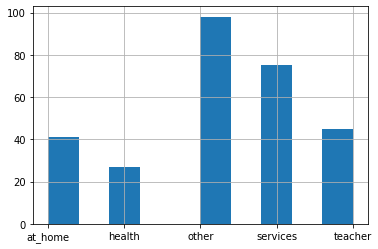

In [587]:
# m_job
display_normalized_values_for(data.m_job)
data.m_job.hist()

# видим что 4% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.m_job)

# думаю, наиболее правильным вариантом в данном случае будет заменить пропуски в работе матери
# на работу отца. не думаю, что эти значения окажут какое-то сильное влияние на конечный результат.
# в случае отсутсвия обоих данных - удалим такие строки
data = data.dropna(subset=['m_job', 'f_job'], how='all')
data.m_job = np.where(data.m_job.isna(), data['f_job'], data['m_job'])

other       0.506711
services    0.255034
NaN         0.080537
teacher     0.073826
at_home     0.043624
health      0.040268
Name: f_job, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,NaN,course,mother,1.0,2.0,0.0,no,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,NaN,home,mother,1.0,1.0,0.0,no,yes,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,NaN,reputation,mother,2.0,2.0,0.0,no,yes,NaN,yes,yes,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,NaN,course,father,2.0,2.0,1.0,yes,no,no,NaN,yes,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
52,GP,M,15,R,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,NaN,reputation,mother,2.0,2.0,0.0,yes,yes,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
107,GP,M,16,U,GT3,T,3.0,3.0,services,NaN,home,father,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,2.0,90.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,NaN,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,NaN,reputation,other,2.0,3.0,2.0,no,yes,yes,yes,NaN,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0


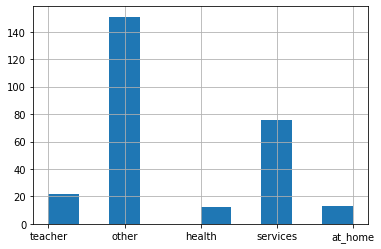

In [588]:
# f_job
display_normalized_values_for(data.f_job)
data.f_job.hist()

# видим что 8% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.f_job)

# у меня появилась другая идея, привязать работу родителя к его уровню образования.
# оставим замену для работы матери как есть, поскольку там пропущенных значений в 2 раза меньше
# чем для работы отца, а для работы отца применим подход где
# уровень образования 4 - health, 3 - teacher, 2 - services, 1 - at_home

values_dictionary = {
    4: 'health',
    3: 'teacher',
    2: 'services',
    1: 'at_home'
}
for key, value in values_dictionary.items():
    data.loc[(data['f_education'] == key) & (data['f_job'].isna()), 'f_job'] = value

In [589]:
# reason
display(data.reason.value_counts())
display_normalized_values_for(data.reason)

# видим что 4% информации отсутсвует, рассмотрим отсутвующие данные
display_absent_values_for(data.reason)

# сложно делать какие-либо выводы об этом столбце, да и не думаю что он имеет отношение
# к оценкам. возможно имеет отношение пункт 'course', то есть образовательная программа,
# но это не значит что в других школах она хуже, просто кто-то руководствуется
# другими причинами при выборе школы. 
# позволю себе удалить данный столбец как нерелевантный
data.drop(['reason'], inplace=True, axis=1)

course        106
reputation     78
home           73
other          27
Name: reason, dtype: int64

course        0.355705
reputation    0.261745
home          0.244966
other         0.090604
NaN           0.046980
Name: reason, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
63,GP,F,16,U,GT3,T,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
73,GP,M,16,U,GT3,T,3.0,1.0,other,other,NaN,mother,1.0,1.0,0.0,no,no,no,yes,yes,yes,no,no,5.0,3.0,2.0,5.0,2.0,70.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
185,GP,M,17,U,GT3,T,3.0,3.0,services,services,NaN,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,NaN,yes,4.0,3.0,4.0,4.0,12.0,55.0
186,GP,M,16,U,GT3,T,1.0,2.0,services,services,NaN,mother,1.0,1.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,3.0,3.0,3.0,2.0,55.0
196,GP,M,17,U,GT3,T,4.0,4.0,services,teacher,NaN,mother,1.0,1.0,0.0,no,no,no,no,yes,yes,yes,no,5.0,2.0,3.0,5.0,4.0,80.0
263,GP,F,17,U,GT3,T,3.0,3.0,other,other,NaN,mother,1.0,3.0,0.0,no,no,NaN,yes,no,yes,no,no,3.0,2.0,3.0,4.0,4.0,45.0
335,GP,F,17,U,GT3,T,3.0,4.0,services,other,NaN,mother,1.0,3.0,0.0,no,NaN,no,no,yes,yes,yes,no,4.0,4.0,5.0,5.0,16.0,75.0


In [590]:
# guardian
display(data.guardian.value_counts())
display_normalized_values_for(data.guardian)

# данный столбец мне не совсем понятен. что значит опекун мать/отец
# если семья полная, то очевидно что оба родителя выполняют свои функции, а не кто-то один
# однако все же рассмотрим отсутсвующие значения, возможно найдем способ для замены данных
display_absent_values_for(data.guardian)

# сложно предположить какие-либо варианты для замены. удалим этот столбец
data.drop(['guardian'], inplace=True, axis=1)

mother    186
father     72
other      13
Name: guardian, dtype: int64

mother    0.624161
father    0.241611
NaN       0.090604
other     0.043624
Name: guardian, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,guardian,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,NaN,1.0,3.0,0.0,yes,NaN,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
41,GP,M,15,U,LE3,T,4.0,4.0,teacher,other,NaN,1.0,1.0,0.0,no,yes,no,no,no,yes,yes,NaN,5.0,4.0,3.0,5.0,8.0,60.0
49,GP,F,15,U,GT3,T,4.0,4.0,services,teacher,NaN,1.0,2.0,1.0,yes,yes,no,yes,no,yes,yes,no,4.0,4.0,4.0,3.0,2.0,35.0
53,GP,F,15,U,GT3,T,4.0,4.0,services,services,NaN,1.0,1.0,0.0,yes,yes,yes,no,yes,yes,yes,no,3.0,3.0,4.0,5.0,0.0,55.0
60,GP,F,16,R,GT3,T,4.0,4.0,health,teacher,NaN,1.0,2.0,0.0,no,yes,no,yes,yes,yes,no,no,2.0,4.0,4.0,4.0,6.0,55.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
90,GP,F,16,U,GT3,T,3.0,3.0,other,other,NaN,1.0,3.0,0.0,no,yes,yes,no,yes,yes,yes,yes,4.0,3.0,3.0,4.0,0.0,40.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,NaN,1.0,1.0,0.0,no,NaN,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
138,GP,M,16,U,LE3,T,1.0,1.0,services,other,NaN,1.0,2.0,1.0,no,no,no,no,yes,yes,no,yes,4.0,4.0,4.0,5.0,0.0,60.0
164,GP,M,17,R,LE3,T,1.0,1.0,other,services,NaN,4.0,2.0,3.0,no,no,NaN,yes,yes,no,no,yes,5.0,3.0,5.0,NaN,0.0,35.0


no     249
yes     41
Name: school_support, dtype: int64

no     0.835570
yes    0.137584
NaN    0.026846
Name: school_support, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
27,GP,M,15,U,GT3,T,4.0,2.0,health,services,1.0,1.0,0.0,NaN,no,yes,no,yes,yes,yes,NaN,2.0,2.0,4.0,1.0,4.0,75.0
35,GP,F,15,U,GT3,T,2.0,3.0,other,other,1.0,1.0,0.0,NaN,yes,no,yes,yes,yes,no,no,3.0,5.0,1.0,5.0,0.0,30.0
79,GP,F,16,U,GT3,T,3.0,4.0,at_home,other,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,at_home,1.0,1.0,1.0,NaN,no,no,yes,yes,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
211,GP,M,17,U,LE3,T,4.0,4.0,services,other,1.0,2.0,0.0,NaN,yes,yes,no,yes,yes,yes,yes,5.0,3.0,5.0,3.0,13.0,65.0
274,GP,F,17,U,GT3,T,2.0,4.0,at_home,health,2.0,2.0,0.0,NaN,yes,yes,no,yes,yes,yes,yes,4.0,3.0,3.0,1.0,2.0,50.0
321,GP,F,17,U,GT3,T,2.0,2.0,other,other,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,no,yes,4.0,2.0,2.0,3.0,12.0,45.0
394,MS,M,19,U,LE3,T,1.0,1.0,other,at_home,1.0,1.0,0.0,NaN,no,no,no,yes,yes,yes,no,3.0,2.0,3.0,5.0,5.0,45.0


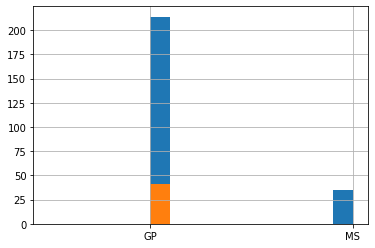

In [591]:
# school_support
display(data.school_support.value_counts())
display_normalized_values_for(data.school_support)

#видим что в большинстве случаев дополнительной поддержки нет. при этом небольшая часть данных (2.5%) пропущена
# рассмотрим отсутсвующие данные

display_absent_values_for(data.school_support)

#  возможно, наличие поддержки связано с типом школы. проверим эту гипотезу
data.groupby(by=['school_support'])['school'].hist()

# видим что поддержка есть только в школе GP, однако в связи с малочисленностью 
# данных о наличии поддержки мы не можем однозначно сказать что все остальные данные можно 
# заменить на наличие поддержки. Поскольку в школе MS данных о поддержке нет
# то в ней мы заменим отсутвующее значение на 'no'
data.loc[(data['school'] == 'MS') & (data['school_support'].isna()), 'school_support'] = 'no'

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.school_support)

In [592]:
# family_support
display(data.family_support.value_counts())
display_normalized_values_for(data.family_support)

# видим что в отличие от школьной поддержки, более половины учеников занимаются в семье
# 8% данных пропущено, рассмотрим их
display_absent_values_for(data.family_support)

# на данный момент не представляется возможным как-либо заполнить пропуски

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.family_support)

yes    171
no     101
Name: family_support, dtype: int64

yes    0.573826
no     0.338926
NaN    0.087248
Name: family_support, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,services,1.0,2.0,0.0,0,NaN,no,yes,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
28,GP,M,16,U,LE3,T,3.0,4.0,services,other,1.0,2.0,0.0,1,NaN,no,yes,yes,yes,yes,no,5.0,3.0,3.0,5.0,4.0,55.0
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,1.0,2.0,0.0,0,NaN,no,yes,no,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
38,GP,F,15,R,GT3,T,3.0,4.0,services,health,1.0,3.0,0.0,1,NaN,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,2.0,55.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,1.0,2.0,0.0,0,NaN,NaN,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
52,GP,M,15,R,LE3,A,4.0,2.0,health,services,2.0,1.0,1.0,0,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
61,GP,F,16,U,GT3,T,1.0,1.0,services,services,4.0,1.0,0.0,1,NaN,no,yes,no,yes,yes,yes,5.0,5.0,5.0,5.0,6.0,55.0
78,GP,M,17,U,GT3,T,2.0,1.0,other,other,2.0,1.0,3.0,1,NaN,no,yes,yes,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,1.0,1.0,0.0,0,NaN,no,yes,no,yes,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
127,GP,F,19,U,GT3,T,0.0,1.0,at_home,other,1.0,2.0,3.0,0,NaN,no,no,no,no,no,no,3.0,4.0,2.0,5.0,2.0,45.0


In [593]:
# paid
display(data.paid.value_counts())
display_normalized_values_for(data.paid)

# видим что распределение учеников с платными занятиями и без них приблизительно равное, при этом 11% данных пропущено
display_absent_values_for(data.paid)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.paid)

no     142
yes    123
Name: paid, dtype: int64

no     0.476510
yes    0.412752
NaN    0.110738
Name: paid, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,1.0,2.0,3.0,1,0,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
18,GP,M,17,U,GT3,T,3.0,2.0,services,services,1.0,1.0,3.0,0,1,NaN,yes,yes,yes,yes,no,5.0,5.0,5.0,5.0,16.0,25.0
19,GP,M,16,U,LE3,T,4.0,3.0,health,other,1.0,1.0,0.0,0,0,NaN,yes,yes,yes,yes,no,3.0,1.0,3.0,5.0,4.0,50.0
21,GP,M,15,U,GT3,T,4.0,4.0,health,health,1.0,1.0,0.0,0,1,NaN,no,yes,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
26,GP,M,15,U,GT3,T,2.0,2.0,other,services,1.0,1.0,0.0,0,1,NaN,no,yes,yes,yes,NaN,4.0,2.0,2.0,5.0,2.0,55.0
31,GP,M,15,U,GT3,T,4.0,4.0,services,health,2.0,2.0,0.0,0,1,NaN,yes,yes,yes,yes,no,4.0,3.0,1.0,5.0,0.0,85.0
51,GP,F,15,U,LE3,T,4.0,2.0,health,other,1.0,2.0,0.0,0,0,NaN,no,yes,yes,yes,NaN,4.0,3.0,3.0,5.0,2.0,65.0
57,GP,M,15,U,GT3,T,4.0,4.0,teacher,health,1.0,2.0,0.0,0,1,NaN,yes,yes,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
68,GP,F,15,R,LE3,T,2.0,2.0,health,services,2.0,2.0,0.0,1,1,NaN,no,yes,yes,yes,no,4.0,1.0,3.0,4.0,2.0,40.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,1.0,3.0,0.0,1,0,NaN,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0


In [594]:
# activities
display(data.activities.value_counts())
display_normalized_values_for(data.activities)

# видим что распределение учеников с доп занятиями и без них приблизительно равное, при этом 4% данных пропущено
display_absent_values_for(data.activities)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.activities)

yes    147
no     139
Name: activities, dtype: int64

yes    0.493289
no     0.466443
NaN    0.040268
Name: activities, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
43,GP,M,15,U,GT3,T,2.0,2.0,services,services,1.0,1.0,0.0,1,1,0,NaN,yes,yes,yes,no,5.0,4.0,1.0,1.0,0.0,55.0
44,GP,F,16,U,LE3,T,2.0,2.0,other,services,2.0,2.0,1.0,1,0,0,NaN,yes,yes,yes,no,4.0,3.0,3.0,5.0,14.0,45.0
54,GP,F,15,U,LE3,T,3.0,3.0,other,other,1.0,1.0,0.0,0,0,1,NaN,yes,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
81,GP,M,15,U,GT3,T,2.0,3.0,other,other,1.0,3.0,0.0,1,0,0,NaN,no,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
99,GP,F,16,U,GT3,T,4.0,3.0,other,at_home,1.0,3.0,0.0,1,1,1,NaN,yes,yes,yes,no,5.0,3.0,5.0,3.0,0.0,40.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,2.0,2.0,0.0,0,1,0,NaN,yes,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
126,GP,F,15,U,LE3,A,3.0,4.0,other,other,1.0,2.0,0.0,1,0,0,NaN,yes,yes,yes,yes,5.0,3.0,2.0,1.0,0.0,55.0
141,GP,M,16,U,LE3,T,2.0,2.0,services,services,2.0,1.0,2.0,0,1,0,NaN,yes,yes,NaN,no,2.0,3.0,3.0,2.0,8.0,45.0
163,GP,M,17,U,GT3,T,1.0,3.0,at_home,services,1.0,1.0,0.0,0,0,0,NaN,yes,no,yes,no,5.0,3.0,3.0,2.0,2.0,50.0
207,GP,F,16,U,GT3,T,4.0,3.0,teacher,other,1.0,2.0,0.0,0,0,1,NaN,yes,yes,yes,yes,1.0,3.0,2.0,1.0,10.0,65.0


In [595]:
# nursery
display(data.nursery.value_counts())
display_normalized_values_for(data.nursery)

# видим что 77% посещали детский сад, 4% данных пропущено.
display_absent_values_for(data.nursery)

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.nursery)

yes    230
no      56
Name: nursery, dtype: int64

yes    0.771812
no     0.187919
NaN    0.040268
Name: nursery, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
22,GP,M,16,U,LE3,T,4.0,2.0,teacher,services,1.0,2.0,0.0,0,0,0,1,NaN,yes,yes,no,4.0,5.0,1.0,5.0,2.0,80.0
32,GP,M,15,R,GT3,T,4.0,3.0,teacher,at_home,1.0,2.0,0.0,0,1,0,1,NaN,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,80.0
85,GP,F,15,U,GT3,T,4.0,4.0,services,services,2.0,2.0,2.0,0,0,1,0,NaN,yes,yes,yes,4.0,4.0,4.0,5.0,6.0,40.0
88,GP,M,16,U,GT3,T,2.0,2.0,other,other,2.0,2.0,1.0,0,0,1,1,NaN,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,teacher,2.0,3.0,2.0,0,1,1,1,NaN,yes,yes,yes,4.0,2.0,1.0,3.0,8.0,50.0
212,GP,F,16,U,GT3,A,2.0,2.0,other,other,1.0,2.0,0.0,1,1,1,0,NaN,yes,yes,no,3.0,3.0,4.0,4.0,0.0,70.0
249,GP,M,16,U,GT3,T,0.0,2.0,other,other,1.0,1.0,0.0,0,0,1,0,NaN,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
300,GP,F,18,U,LE3,A,4.0,4.0,health,other,1.0,2.0,0.0,0,1,0,0,NaN,yes,yes,yes,4.0,2.0,4.0,4.0,14.0,55.0
336,GP,F,19,R,GT3,A,3.0,1.0,services,at_home,1.0,3.0,1.0,0,0,1,0,NaN,yes,no,no,5.0,4.0,3.0,5.0,12.0,65.0
340,GP,F,19,U,GT3,T,2.0,1.0,services,services,1.0,3.0,1.0,0,0,1,1,NaN,yes,NaN,yes,4.0,3.0,4.0,3.0,4.0,55.0


In [596]:
# higher
display(data.higher.value_counts())
display_normalized_values_for(data.higher)

# видим что 92% хотят получать высшее образование (что радует). отсутвует 2.5% данных, рассмотрим их
display_absent_values_for(data.higher)

# думаю, при таком подавляющем большинстве желающих получать высшее образование, можно заменить отсутсвующие
# данные на большинство
data.higher = data.higher.fillna('yes')

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.higher)

yes    275
no       8
Name: higher, dtype: int64

yes    0.922819
NaN    0.050336
no     0.026846
Name: higher, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
34,GP,M,16,U,GT3,T,3.0,2.0,other,other,1.0,1.0,0.0,0,1,1,0,0,NaN,yes,no,5.0,4.0,3.0,5.0,0.0,75.0
48,GP,M,15,U,GT3,T,4.0,2.0,teacher,other,1.0,2.0,0.0,0,1,1,0,1,NaN,no,no,4.0,3.0,3.0,5.0,2.0,70.0
76,GP,M,15,U,GT3,T,4.0,0.0,teacher,other,2.0,4.0,0.0,0,0,0,1,1,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
84,GP,F,15,U,GT3,T,1.0,1.0,other,other,1.0,2.0,0.0,0,1,0,1,0,NaN,yes,no,4.0,3.0,2.0,4.0,2.0,50.0
96,GP,M,16,R,GT3,T,4.0,3.0,services,other,2.0,1.0,0.0,1,1,0,1,0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
142,GP,F,15,U,GT3,T,4.0,4.0,teacher,services,1.0,3.0,0.0,0,1,1,1,1,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
149,GP,M,15,U,LE3,T,2.0,1.0,services,other,4.0,1.0,3.0,0,0,0,0,1,NaN,yes,no,4.0,5.0,5.0,5.0,0.0,50.0
158,GP,M,16,R,GT3,T,2.0,2.0,at_home,other,3.0,1.0,0.0,0,0,0,0,0,NaN,no,no,4.0,2.0,2.0,3.0,2.0,75.0
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,2.0,2.0,0.0,0,1,1,1,1,NaN,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0
181,GP,M,16,U,GT3,T,3.0,3.0,services,other,1.0,2.0,0.0,0,0,1,1,1,NaN,yes,NaN,4.0,2.0,3.0,3.0,2.0,60.0


In [597]:
# internet
display(data.internet.value_counts())
display_normalized_values_for(data.internet)

# видим что 76.5% имеют доступ в интернет, 14.7% - нет. отсутвует 8% данных, рассмотрим их
display_absent_values_for(data.internet)

# хотелось бы заполнить все пропуски доступом в интернет, но я не Илон Маск чтобы дарить
# людям бесплатный интернет :)

# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.internet)

yes    228
no      44
Name: internet, dtype: int64

yes    0.765101
no     0.147651
NaN    0.087248
Name: internet, dtype: float64


,school,sex,age,address,family_size,parents_status,m_education,f_education,m_job,f_job,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
0,GP,F,18,U,LE3,A,4.0,4.0,at_home,teacher,2.0,2.0,0.0,1,0,0,0,1,1,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
12,GP,M,15,U,LE3,T,4.0,4.0,health,services,1.0,1.0,0.0,0,1,1,1,1,1,NaN,no,5.0,3.0,3.0,5.0,2.0,70.0
52,GP,M,15,R,LE3,A,4.0,2.0,health,services,2.0,1.0,1.0,0,0,0,0,1,1,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
65,GP,F,16,U,LE3,T,4.0,3.0,teacher,services,3.0,2.0,0.0,0,1,0,1,1,1,NaN,no,5.0,4.0,3.0,1.0,2.0,75.0
80,GP,M,15,U,GT3,T,2.0,3.0,other,services,1.0,1.0,0.0,1,1,1,1,0,1,NaN,yes,3.0,2.0,2.0,3.0,2.0,60.0
86,GP,F,16,U,LE3,T,2.0,2.0,at_home,other,1.0,2.0,0.0,0,1,0,0,1,1,NaN,no,4.0,3.0,4.0,2.0,4.0,30.0
98,GP,F,16,U,GT3,T,4.0,4.0,other,other,1.0,1.0,0.0,0,0,0,1,0,1,NaN,no,5.0,3.0,4.0,1.0,6.0,70.0
110,GP,M,15,U,LE3,A,4.0,4.0,teacher,teacher,1.0,1.0,0.0,0,0,0,1,1,1,NaN,no,5.0,5.0,3.0,4.0,6.0,95.0
115,GP,M,16,U,GT3,T,4.0,4.0,teacher,teacher,1.0,2.0,0.0,0,1,0,1,1,1,NaN,no,5.0,4.0,4.0,5.0,2.0,80.0
117,GP,M,16,U,GT3,T,3.0,3.0,other,services,2.0,1.0,0.0,0,0,0,1,1,1,NaN,no,5.0,4.0,2.0,5.0,0.0,65.0


In [598]:
# romantic
display(data.romantic.value_counts())
display_normalized_values_for(data.romantic)

# видим что 63% не состоят в отношениях. 8% данных отсутсвует, рассмотрим их

# на данный момент не представляется возможным как-либо заполнить пропуски
# заменим yes/no на 1/0 для учета этих данных в таблице корреляции
replace_yes_no_with_integers_in(data.romantic)

no     189
yes     84
Name: romantic, dtype: int64

no     0.634228
yes    0.281879
NaN    0.083893
Name: romantic, dtype: float64


In [599]:
## данные после обработки всех столбцов 
data.info()

# осталось 298 записей, часть столбцов была удалена

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 394
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   school            298 non-null    object 
 1   sex               298 non-null    object 
 2   age               298 non-null    int64  
 3   address           298 non-null    object 
 4   family_size       298 non-null    object 
 5   parents_status    298 non-null    object 
 6   m_education       298 non-null    float64
 7   f_education       298 non-null    float64
 8   m_job             298 non-null    object 
 9   f_job             298 non-null    object 
 10  traveltime        298 non-null    float64
 11  studytime         298 non-null    float64
 12  failures          298 non-null    float64
 13  school_support    298 non-null    int64  
 14  family_support    298 non-null    int64  
 15  paid              298 non-null    int64  
 16  activities        298 non-null    int64  
 1

In [600]:
# рассмотрим таблицу корреляции
data.corr()

,age,m_education,f_education,traveltime,studytime,failures,school_support,family_support,paid,activities,nursery,higher,internet,romantic,family_relations,freetime,go_out,health,absences,score
age,1.000000,-0.110855,-0.094823,0.133333,0.048833,0.094626,-0.253919,-0.121662,0.013651,-0.064780,-0.058849,-0.100453,-0.104583,0.133364,0.035188,-0.000826,0.122862,-0.009042,0.155723,-0.097674
m_education,-0.110855,1.000000,0.640239,-0.179014,0.067831,-0.182121,-0.044451,0.137430,0.092554,0.119640,0.143651,0.215935,0.175376,0.056600,0.008588,0.019672,0.024831,-0.038588,0.107511,0.177542
f_education,-0.094823,0.640239,1.000000,-0.171644,-0.036737,-0.255148,0.046687,0.160965,0.035154,0.078351,0.128842,0.146324,0.106826,0.035998,0.000871,0.011277,0.035052,0.006767,0.037992,0.110570
traveltime,0.133333,-0.179014,-0.171644,1.000000,-0.102400,0.149385,-0.012446,-0.084133,-0.045783,-0.001234,-0.049995,-0.135033,-0.050947,0.068363,-0.054361,0.021704,0.052388,0.002425,-0.034003,-0.086208
studytime,0.048833,0.067831,-0.036737,-0.102400,1.000000,-0.123475,0.001257,0.149821,0.224999,0.083215,0.035328,0.110395,0.183834,0.061531,0.054485,-0.136671,0.004804,-0.095025,-0.046878,0.112520
failures,0.094626,-0.182121,-0.255148,0.149385,-0.123475,1.000000,0.092675,-0.042231,-0.101231,-0.027582,-0.102028,-0.307901,-0.082644,0.052692,-0.027411,0.122394,0.089541,0.122215,0.146952,-0.275184
school_support,-0.253919,-0.044451,0.046687,-0.012446,0.001257,0.092675,1.000000,0.048720,-0.038047,-0.004381,0.031471,0.006068,-0.008482,0.009591,0.016849,-0.033817,-0.002762,-0.056612,0.007324,-0.273354
family_support,-0.121662,0.137430,0.160965,-0.084133,0.149821,-0.042231,0.048720,1.000000,0.240093,-0.004782,0.032665,0.108761,0.098725,0.012046,-0.020123,-0.035239,-0.024030,0.013822,0.021354,-0.062394
paid,0.013651,0.092554,0.035154,-0.045783,0.224999,-0.101231,-0.038047,0.240093,1.000000,-0.009196,0.033573,0.139245,0.191208,0.111029,-0.038906,-0.099184,0.019799,-0.071753,-0.072336,0.011023
activities,-0.064780,0.119640,0.078351,-0.001234,0.083215,-0.027582,-0.004381,-0.004782,-0.009196,1.000000,-0.007299,-0.043756,0.040060,0.023329,0.076943,0.058715,0.026222,0.033221,0.070570,0.033441


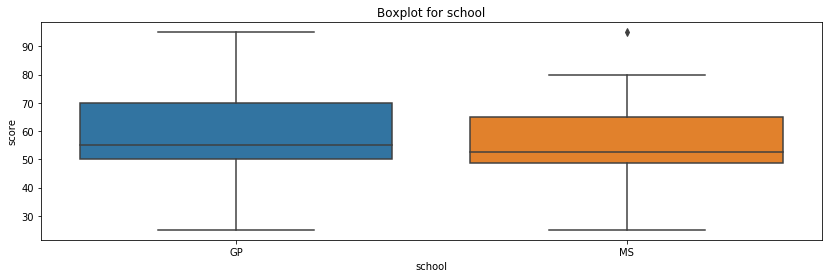

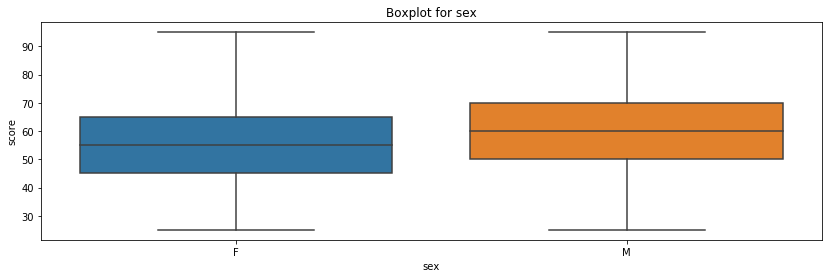

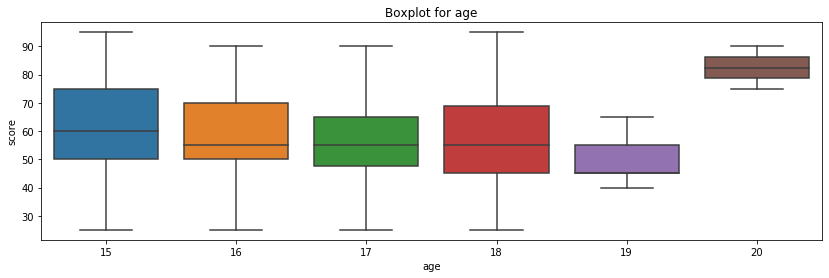

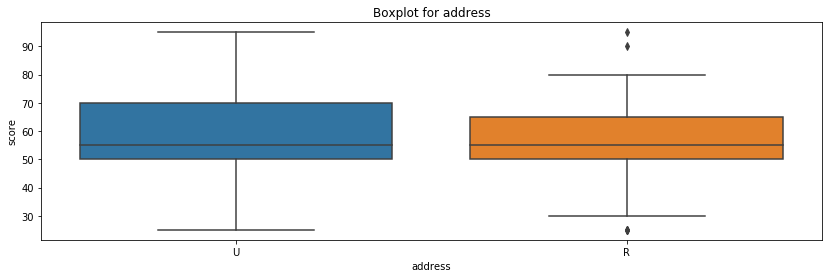

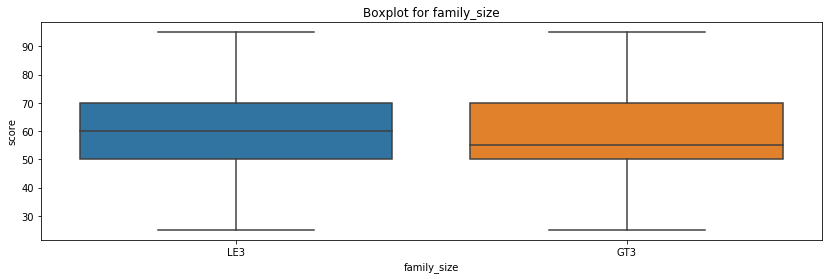

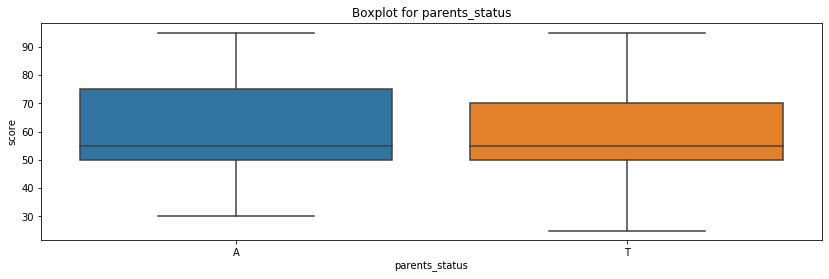

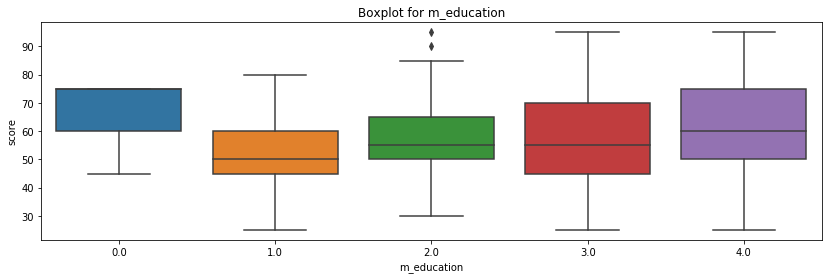

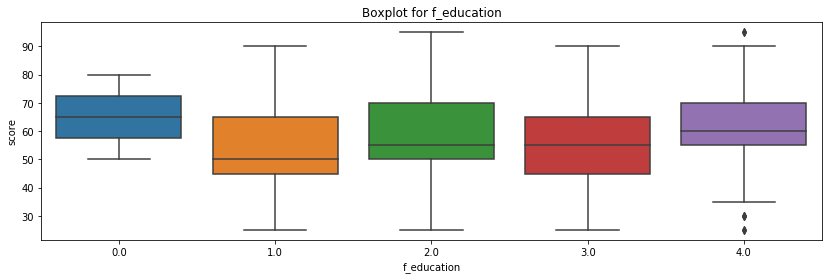

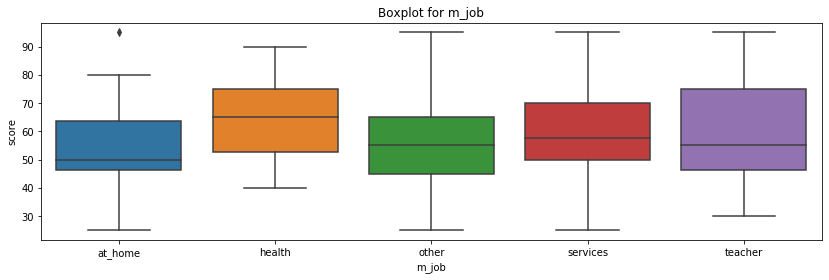

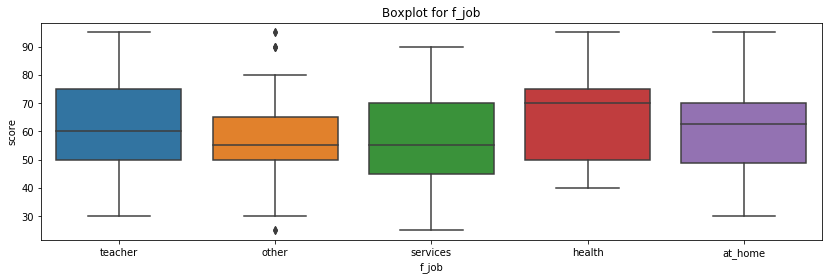

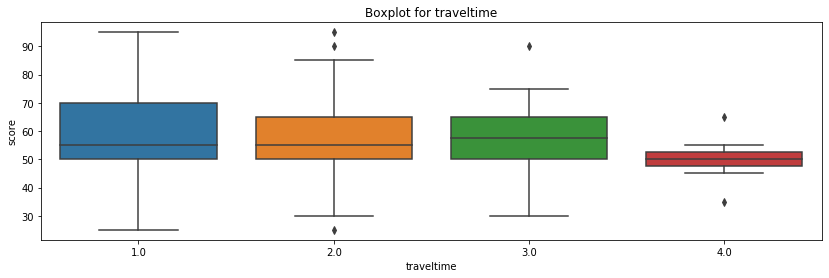

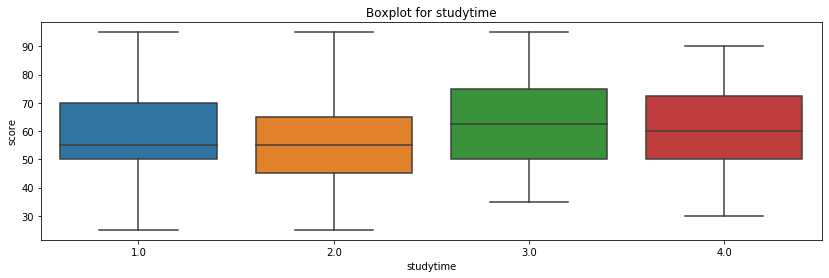

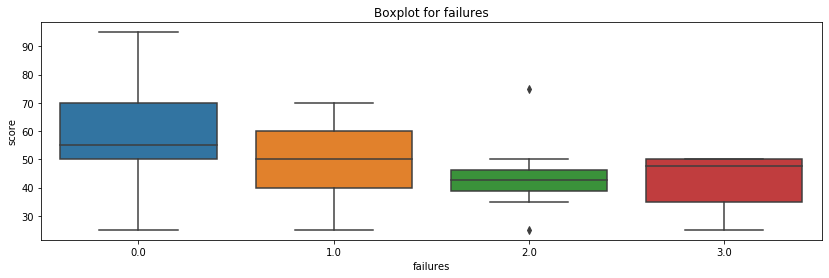

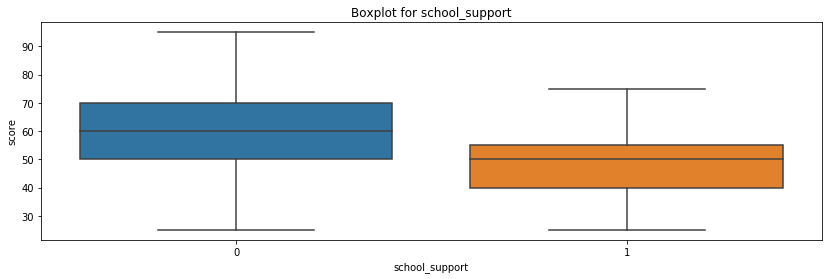

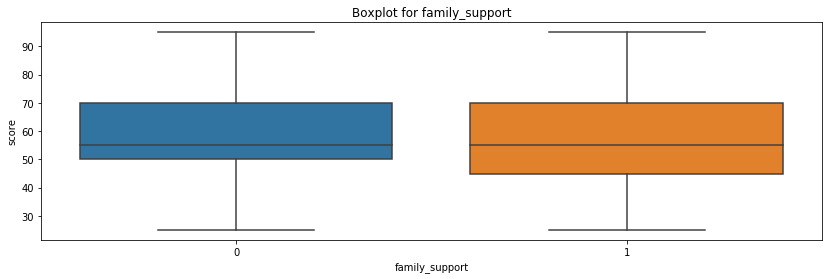

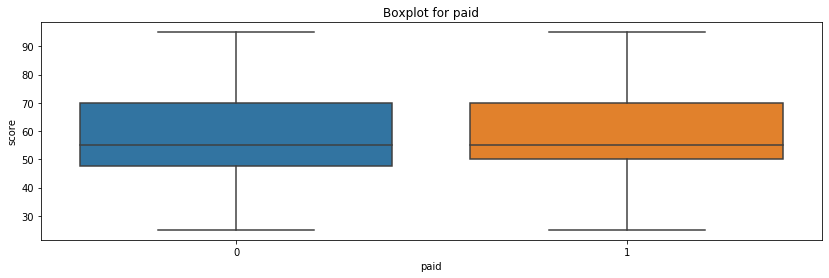

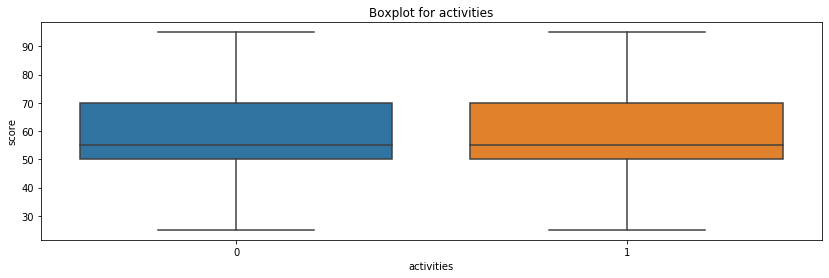

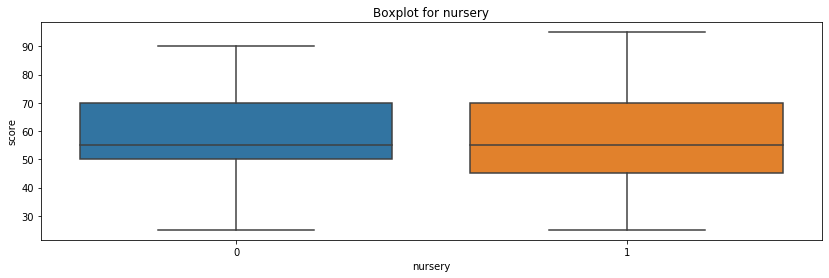

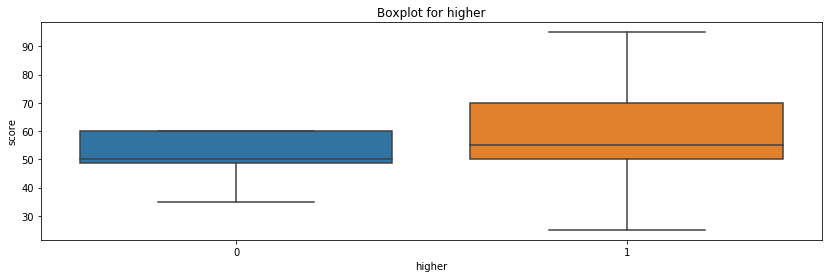

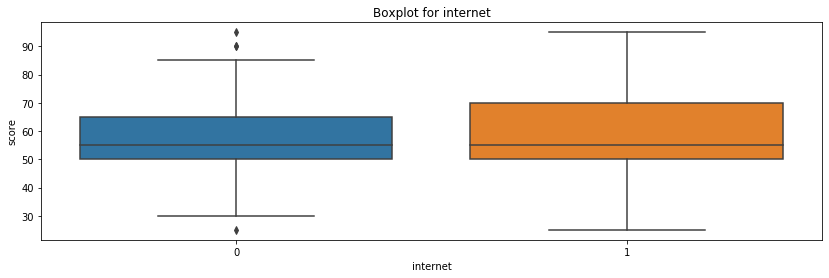

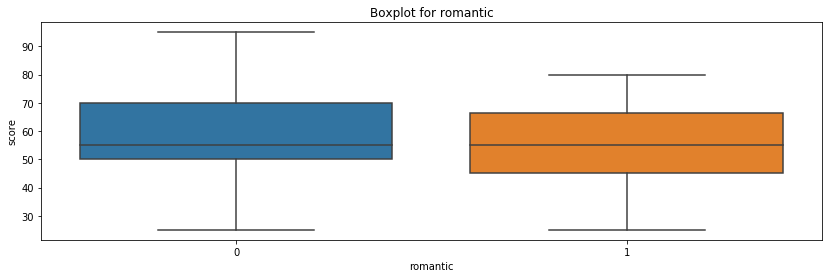

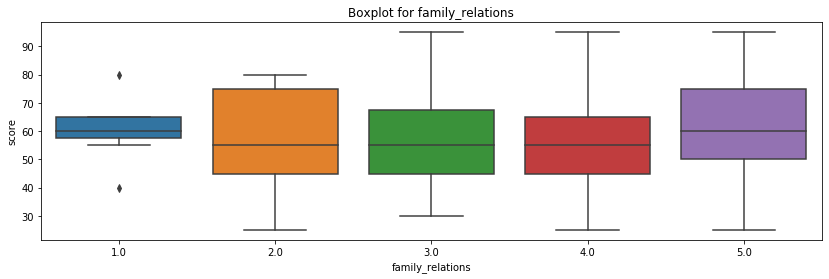

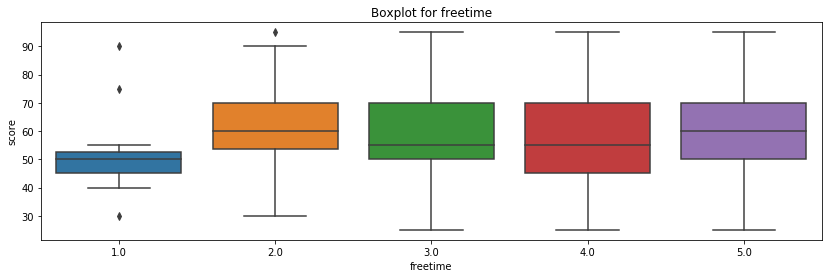

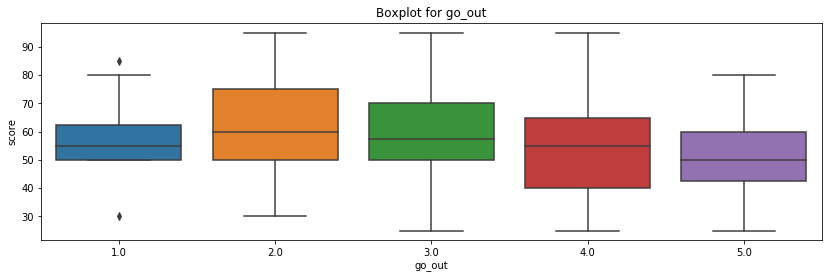

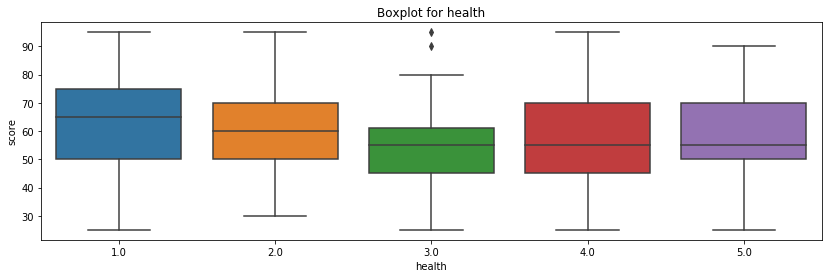

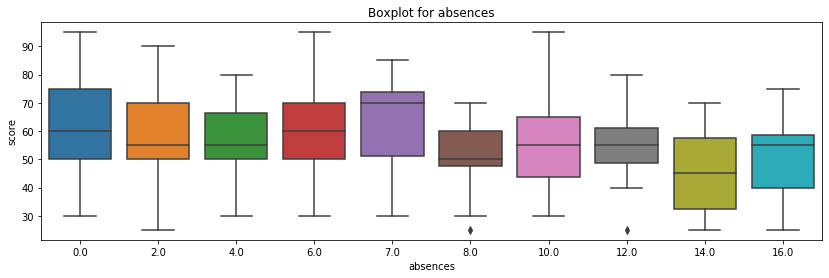

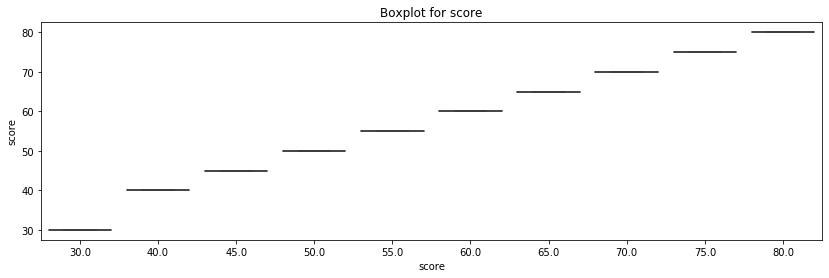

In [601]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in data.columns:
    get_boxplot(col)